In [1]:
%matplotlib inline



# Creating MNE-Python data structures from scratch

This tutorial shows how to create MNE-Python's core data structures using an
existing :class:`NumPy array <numpy.ndarray>` of (real or synthetic) data.

We begin by importing the necessary Python modules:


In [2]:
import mne
import numpy as np

## Creating `~mne.Info` objects

.. sidebar:: Info objects

     For full documentation on the `~mne.Info` object, see
     `tut-info-class`.

The core data structures for continuous (`~mne.io.Raw`), discontinuous
(`~mne.Epochs`), and averaged (`~mne.Evoked`) data all have an ``info``
attribute comprising an `mne.Info` object. When reading recorded data using
one of the functions in the ``mne.io`` submodule, `~mne.Info` objects are
created and populated automatically. But if we want to create a
`~mne.io.Raw`, `~mne.Epochs`, or `~mne.Evoked` object from scratch, we need
to create an appropriate `~mne.Info` object as well. The easiest way to do
this is with the `mne.create_info` function to initialize the required info
fields. Additional fields can be assigned later as one would with a regular
:class:`dictionary <dict>`.

To initialize a minimal `~mne.Info` object requires a list of channel names,
and the sampling frequency. As a convenience for simulated data, channel
names can be provided as a single integer, and the names will be
automatically created as sequential integers (starting with ``0``):



In [3]:
# Create some dummy metadata
n_channels = 32
sampling_freq = 200  # in Hertz
info = mne.create_info(n_channels, sfreq=sampling_freq)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, ...
 chs: 32 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 200.0 Hz
>


You can see in the output above that, by default, the channels are assigned
as type "misc" (where it says ``chs: 32 MISC``). You can assign the channel
type when initializing the `~mne.Info` object if you want:



In [4]:
ch_names = [f'MEG{n:03}' for n in range(1, 10)] + ['EOG001']
ch_types = ['mag', 'grad', 'grad'] * 3 + ['eog']
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
print(info)

<Info | 7 non-empty values
 bads: []
 ch_names: MEG001, MEG002, MEG003, MEG004, MEG005, MEG006, MEG007, MEG008, ...
 chs: 3 Magnetometers, 6 Gradiometers, 1 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 10
 projs: []
 sfreq: 200.0 Hz
>


In [5]:
print(mne.channels.get_builtin_montages())

['EGI_256', 'GSN-HydroCel-128', 'GSN-HydroCel-129', 'GSN-HydroCel-256', 'GSN-HydroCel-257', 'GSN-HydroCel-32', 'GSN-HydroCel-64_1.0', 'GSN-HydroCel-65_1.0', 'biosemi128', 'biosemi16', 'biosemi160', 'biosemi256', 'biosemi32', 'biosemi64', 'easycap-M1', 'easycap-M10', 'mgh60', 'mgh70', 'standard_1005', 'standard_1020', 'standard_alphabetic', 'standard_postfixed', 'standard_prefixed', 'standard_primed', 'artinis-octamon', 'artinis-brite23']


If the channel names follow one of the standard montage naming schemes, their
spatial locations can be automatically added using the
`~mne.Info.set_montage` method:



In [6]:
ch_names = ['Fp1', 'Fp2', 'Fz', 'Cz', 'Pz', 'O1', 'O2']
ch_types = ['eeg'] * 7
info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info.set_montage('standard_1020')

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, Fz, Cz, Pz, O1, O2
 chs: 7 EEG
 custom_ref_applied: False
 dig: 10 items (3 Cardinal, 7 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 200.0 Hz
>

.. sidebar:: Info consistency

    When assigning new values to the fields of an `~mne.Info` object, it is
    important that the fields stay consistent. if there are ``N`` channels:

    - The length of the channel information field ``chs`` must be ``N``.
    - The length of the ``ch_names`` field must be ``N``.
    - The ``ch_names`` field should be consistent with the ``name``
      field of the channel information contained in ``chs``.

Note the new field ``dig`` that includes our seven channel locations as well
as theoretical values for the three
:term:`cardinal scalp landmarks <fiducial point>`.

Additional fields can be added in the same way that Python dictionaries are
modified, using square-bracket key assignment:



In [7]:
info['description'] = 'My custom dataset'
info['bads'] = ['O1']  # Names of bad channels
print(info)

<Info | 10 non-empty values
 bads: 1 items (O1)
 ch_names: Fp1, Fp2, Fz, Cz, Pz, O1, O2
 chs: 7 EEG
 custom_ref_applied: False
 description: My custom dataset
 dig: 10 items (3 Cardinal, 7 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 200.0 Hz
>


## Creating `~mne.io.Raw` objects

.. sidebar:: Units

    The expected units for the different channel types are:

    - Volts: eeg, eog, seeg, dbs, emg, ecg, bio, ecog
    - Teslas: mag
    - Teslas/meter: grad
    - Molar: hbo, hbr
    - Amperes: dipole
    - Arbitrary units: misc

To create a `~mne.io.Raw` object from scratch, you can use the
`mne.io.RawArray` class constructor, which takes an `~mne.Info` object and a
:class:`NumPy array <numpy.ndarray>` of shape ``(n_channels, n_samples)``.
Here, we'll create some sinusoidal data and plot it:



In [8]:
times = np.linspace(0, 1, sampling_freq, endpoint=False)
sine = np.sin(20 * np.pi * times)
cosine = np.cos(10 * np.pi * times)
data = np.array([sine, cosine])

info = mne.create_info(ch_names=['10 Hz sine', '5 Hz cosine'],
                       ch_types=['misc'] * 2,
                       sfreq=sampling_freq)

simulated_raw = mne.io.RawArray(data, info)
simulated_raw.plot(show_scrollbars=False, show_scalebars=False)

Creating RawArray with float64 data, n_channels=2, n_times=200
    Range : 0 ... 199 =      0.000 ...     0.995 secs
Ready.
Using qt as 2D backend.
Opening raw-browser...
Using pyopengl with version 3.1.6


qt.qpa.drawing: Layer-backing can not be explicitly controlled on 10.14 when built against the 10.14 SDK


## Creating `~mne.Epochs` objects

To create an `~mne.Epochs` object from scratch, you can use the
`mne.EpochsArray` class constructor, which takes an `~mne.Info` object and a
:class:`NumPy array <numpy.ndarray>` of shape ``(n_epochs, n_channels,
n_samples)``. Here we'll create 5 epochs of our 2-channel data, and plot it.
Notice that we have to pass ``picks='misc'`` to the `~mne.Epochs.plot`
method, because by default it only plots :term:`data channels`.



In [9]:
data = np.array([[0.2 * sine, 1.0 * cosine],
                 [0.4 * sine, 0.8 * cosine],
                 [0.6 * sine, 0.6 * cosine],
                 [0.8 * sine, 0.4 * cosine],
                 [1.0 * sine, 0.2 * cosine]])

simulated_epochs = mne.EpochsArray(data, info)
simulated_epochs.plot(picks='misc', show_scrollbars=False)

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Opening epochs-browser...
Using pyopengl with version 3.1.6


Since we did not supply an events array, the `~mne.EpochsArray` constructor
automatically created one for us, with all epochs having the same event
number:



In [21]:
print(simulated_epochs.events[:, -1])
simulated_epochs

[1 2 1 2 1]


Number of events,5
Events,condition_A: 3condition_B: 2
Time range,-0.500 – 0.495 sec
Baseline,off


If we want to simulate having different experimental conditions, we can pass
an event array (and an event ID dictionary) to the constructor. Since our
epochs are 1 second long and have 200 samples/second, we'll put our events
spaced 200 samples apart, and pass ``tmin=-0.5``, so that the events
land in the middle of each epoch (the events are always placed at time=0 in
each epoch).



In [11]:
simulated_epochs.info

<Info | 7 non-empty values
 bads: []
 ch_names: 10 Hz sine, 5 Hz cosine
 chs: 2 misc
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 2
 projs: []
 sfreq: 200.0 Hz
>

In [12]:
events = np.column_stack((np.arange(0, 1000, sampling_freq),
                          np.zeros(5, dtype=int),
                          np.array([1, 2, 1, 2, 1])))
event_dict = dict(condition_A=1, condition_B=2)
simulated_epochs = mne.EpochsArray(data, info, tmin=-0.5, events=events,
                                   event_id=event_dict)
simulated_epochs.plot(picks='misc', show_scrollbars=False, events=events,
                      event_id=event_dict)

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Opening epochs-browser...
Using pyopengl with version 3.1.6


You could also create simulated epochs by using the normal `~mne.Epochs`
(not `~mne.EpochsArray`) constructor on the simulated `~mne.io.RawArray`
object, by creating an events array (e.g., using
`mne.make_fixed_length_events`) and extracting epochs around those events.


## Creating `~mne.Evoked` Objects

If you already have data that was averaged across trials, you can use it to
create an `~mne.Evoked` object using the `~mne.EvokedArray` class
constructor.  It requires an `~mne.Info` object and a data array of shape
``(n_channels, n_times)``, and has an optional ``tmin`` parameter like
`~mne.EpochsArray` does. It also has a parameter ``nave`` indicating how many
trials were averaged together, and a ``comment`` parameter useful for keeping
track of experimental conditions, etc. Here we'll do the averaging on our
NumPy array and use the resulting averaged data to make our `~mne.Evoked`.



<Evoked | 'simulated' (average, N=5), -0.5 – 0.495 sec, baseline off, 2 ch, ~10 kB>


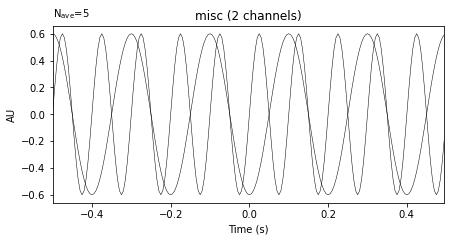

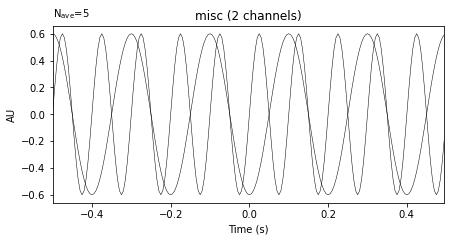

In [13]:
# Create the Evoked object
evoked_array = mne.EvokedArray(data.mean(axis=0), info, tmin=-0.5,
                               nave=data.shape[0], comment='simulated')
print(evoked_array)
evoked_array.plot()

In [15]:
sim_epc=simulated_epochs.copy()

In [19]:
from matplotlib import pyplot as plt


info.plot_sensors(show_names=True)

AttributeError: 'Info' object has no attribute 'plot_sensors'

In [ ]:
ch_names = ['E22', 'E9', 'E6', 'E55', 'E62', 'E74', 'E82']
ch_types = ['eeg'] * 7
info_egi = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
info_egi.set_montage('GSN-HydroCel-128')

<Info | 8 non-empty values
 bads: []
 ch_names: E22, E9, E6, E55, E62, E74, E82
 chs: 7 EEG
 custom_ref_applied: False
 dig: 10 items (3 Cardinal, 7 EEG)
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: unspecified
 nchan: 7
 projs: []
 sfreq: 200.0 Hz
>

In [ ]:
from matplotlib import pyplot as plt

sensors_1020=info_1020.copy()
sensors_egi=info_egi.copy()

fig = plt.figure(figsize=(20, 25))
ax3d = fig.add_subplot(121,projection='3d')
ax2d = fig.add_subplot(122)
sensors_1020.plot_sensors(axes=ax2d,show=False,show_names=True)
sensors_egi.plot_sensors(axes=ax2d,show=False,show_names=True)
ax3d.view_init(azim=70, elev=5)